In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()

In [4]:
import matplotlib.pyplot as plt

def plot_experiment(node_data):
    plt.rcParams["figure.figsize"] = (8,5)
    
    a,b,c,d = node_data
    
    plt.scatter(a.humidity, a.temperature, marker= ".", label="pi2", alpha =0.5)
    plt.scatter(b.humidity, b.temperature, marker = "v", label="pi3", alpha=0.5)
    plt.scatter(c.humidity, c.temperature, marker = "^", label="pi4", alpha=0.5)
    plt.scatter(d.humidity, d.temperature, marker = "*", label="pi5", alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel="Humidity")
    plt.ylabel(ylabel="Temperature")
    plt.show()

def plot_experiments():
    for i in range(1,4):
        node_data = get_node_data(data, experiment =i)
        plot_experiment(node_data)

## Outliers removed with OCSVM

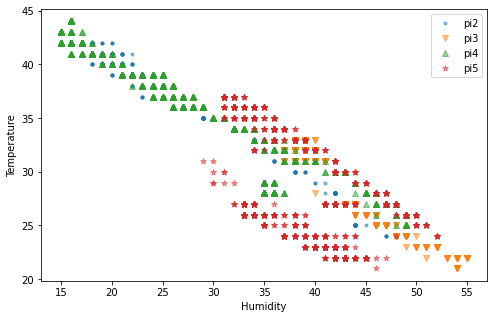

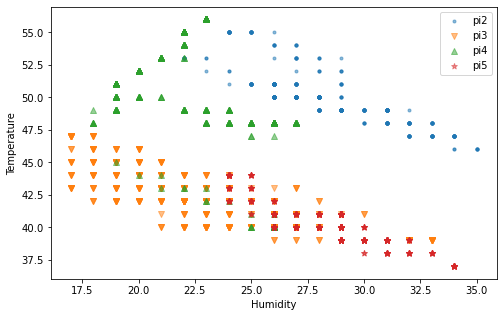

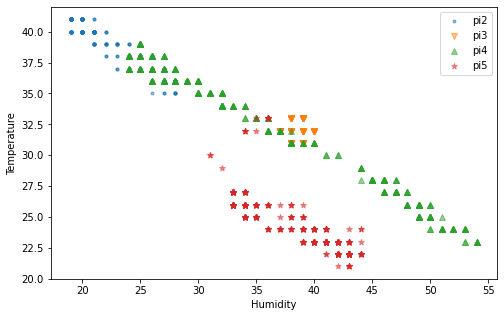

In [5]:
plot_experiments()

### When outliers are not removed with OCSVM

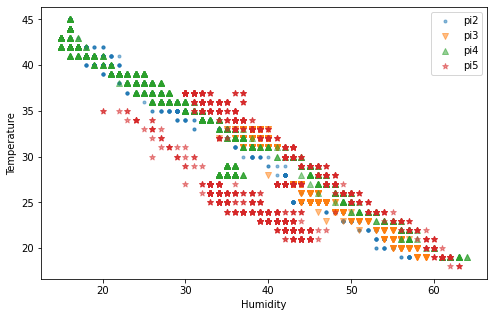

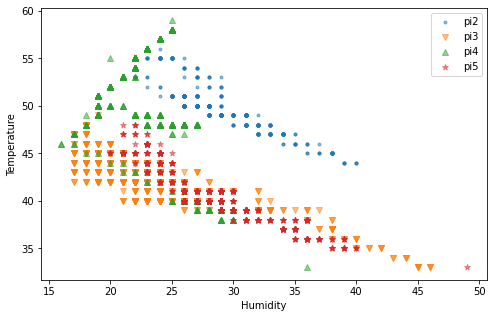

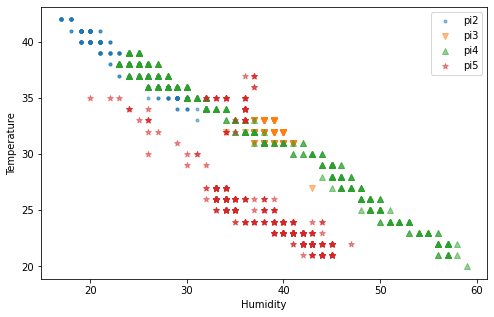

In [5]:
plot_experiments()

In [4]:
from maximum_mean_discrepancy import MMD, get_tensor_samples
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASD_MMD
from prettytable import PrettyTable
    
def print_mmd(x,y, kernel, kernel_bandwidth):  
    result = MMD(x,y, kernel, kernel_bandwidth)
    print(f"mmd result of X and Y is {result.item()}")

def bandwidth_experiment(samples, similar_sets, dissimilar_sets, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASD_MMD(samples, similar_sets, dissimilar_sets, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

## Observations

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [5]:
m = 200
samples = get_tensor_samples(data, experiment=1, sample_size=m)

In [6]:
similar_sets = ["pi2","pi4"]
dissimilar_sets = ["pi3","pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(2.0339) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(32.9921) |
| ('pi3', 'pi4') | tensor(32.4272) |
| ('pi5', 'pi2') | tensor(27.7680) |
| ('pi5', 'pi4') | tensor(27.0771) |
| ('pi3', 'pi5') |  tensor(3.7611) |
+----------------+-----------------+

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(6.1016) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(98.9763) |
| ('pi3', 'pi4') | tensor(97.2816) |
| ('pi5', 'pi2') | tensor(83.3041) |
| ('pi5', 'pi4') | tensor(81.2314) |
| ('pi3', 'pi5') | tensor(11.2832) |
+

In [7]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(3.7611) |
| ('pi2', 'pi4') | tensor(2.0339) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(32.9921) |
| ('pi2', 'pi5') | tensor(27.7680) |
| ('pi4', 'pi3') | tensor(32.4272) |
| ('pi4', 'pi5') | tensor(27.0771) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(11.2832) |
| ('pi2', 'pi4') |  tensor(6.1016) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(98.9764) |
| ('pi2', 'pi5') | tensor(83.3041) |
| ('pi4', 'pi3') | tensor(97.2816) |
| ('pi4', 'pi5') | tensor(81.2314)

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [8]:
samples = get_tensor_samples(data, experiment=3, sample_size=m)

In [10]:
similar_sets = ["pi3", "pi4", "pi5"]
dissimilar_sets = ["pi2"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi4') | tensor(2.6549) |
| ('pi3', 'pi5') | tensor(8.0965) |
| ('pi4', 'pi5') | tensor(7.6128) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(31.5474) |
| ('pi2', 'pi4') | tensor(27.8966) |
| ('pi2', 'pi5') | tensor(46.8245) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi4') |  tensor(7.9648) |
| ('pi3', 'pi5') | tensor(24.2892) |
| ('pi4', 'pi5') | tensor(22.8384) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi2', 'pi3') | tensor(94.6422)  |
| ('pi2', 'pi4') | tensor(83.6899)  |
| ('pi2', 'pi5') | tensor(140.

In [11]:
similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(31.5474) |
| ('pi2', 'pi4') | tensor(27.8966) |
| ('pi3', 'pi4') |  tensor(2.6549) |
| ('pi5', 'pi3') |  tensor(8.0964) |
| ('pi5', 'pi4') |  tensor(7.6128) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(46.8244) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(94.6422) |
| ('pi2', 'pi4') | tensor(83.6899) |
| ('pi3', 'pi4') |  tensor(7.9648) |
| ('pi5', 'pi3') | tensor(24.2892) |
| ('pi5', 'pi4') | tensor(22.8382) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor

### Experiment 2

In [12]:
samples = get_tensor_samples(data, experiment=2, sample_size=m)

In [13]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(6.0840) |
| ('pi2', 'pi4') | tensor(6.8493) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(11.9814) |
| ('pi2', 'pi5') | tensor(12.2551) |
| ('pi4', 'pi3') | tensor(10.6168) |
| ('pi4', 'pi5') | tensor(18.1705) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(18.2523) |
| ('pi2', 'pi4') | tensor(20.5479) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(35.9441) |
| ('pi2', 'pi5') | tensor(36.7654) |
| ('pi4', 'pi3') | tensor(31.8503) |
| ('pi4', 'pi5') | tensor(54.5113)

# Classifier Experiments

For now let's only consider the data from experiment 2 because they match both the plot and MMD results that pi3 and pi5 have a similar distribution and pi2 and pi4 are the dissimilar nodes.

## Trainning and optimising individual models for each node

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split

def lr():
    return LogisticRegression()

def svr(linear=False):
    if linear:
        return LinearSVR(random_state=0, max_iter=1000000)
    else:
        return SVR()


def fit_clf(clf, train, test):
    clf.fit(train.temperature.values.reshape(-1, 1), train.humidity.values)
    return clf.score(test.temperature.values.reshape(-1, 1), test.humidity.values)

# lr = LR()
# svr = SVR()

In [15]:
node_data = get_node_data(data, experiment = 2)

In [16]:
model_data = {}
for i in range(2,6):
    model = svr()
    train, test = train_test_split(node_data[i-2])
    score = fit_clf(model, train, test)
    print(f"Baseline Model Accuracy for node pi{i}: {score}")
    model_data["pi"+str(i)] = [train, test]

Baseline Model Accuracy for node pi2: 0.8369526521307266
Baseline Model Accuracy for node pi3: 0.591445626316046
Baseline Model Accuracy for node pi4: 0.7904103375085703
Baseline Model Accuracy for node pi5: 0.7091585843790521


In [17]:
from sklearn.model_selection import GridSearchCV
svr_param_grid = {"kernel": ["rbf", "linear"],
                 "C" : [0.1, 0.5, 1, 2, 5],
                 "epsilon" : [0.05, 0.1, 0.15, 0.2]
                }

In [18]:
for i in range(4):
    grid_search = GridSearchCV( SVR(), svr_param_grid)
    train, test = model_data["pi"+str(i+2)]
    grid_search.fit(train.temperature.values.reshape(-1,1), train.humidity.values)
    best_params= grid_search.best_params_
    print(f"The best parameter settings for node pi{i+2} are: {best_params}")

The best parameter settings for node pi2 are: {'C': 1, 'epsilon': 0.2, 'kernel': 'rbf'}
The best parameter settings for node pi3 are: {'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}
The best parameter settings for node pi4 are: {'C': 5, 'epsilon': 0.2, 'kernel': 'rbf'}
The best parameter settings for node pi5 are: {'C': 5, 'epsilon': 0.05, 'kernel': 'rbf'}


In [19]:
## Node pi2
model_pi2 = SVR(C=1, epsilon=0.2, kernel="rbf")
train, test = model_data["pi2"]
score = fit_clf(model_pi2, train, test)
print(f"Optimised Model Accuracy for node pi2: {score}")

Optimised Model Accuracy for node pi2: 0.8405921749461136


In [20]:
## Node pi3
model_pi3 = SVR(C=5, epsilon=0.2, kernel="rbf")
train, test = model_data["pi3"]
score = fit_clf(model_pi3, train, test)
print(f"Optimised Model Accuracy for node pi3: {score}")

Optimised Model Accuracy for node pi3: 0.6453187026991247


In [21]:
## Node pi4
model_pi4 = SVR(C=1, epsilon=0.2, kernel="rbf")
train, test = model_data["pi4"]
score = fit_clf(model_pi4, train, test)
print(f"Optimised Model Accuracy for node pi4: {score}")

Optimised Model Accuracy for node pi4: 0.7886990824074904


In [23]:
## Node pi5
model_pi5 = SVR(C=5, epsilon=0.05, kernel="rbf")
train, test = model_data["pi5"]
score = fit_clf(model_pi5, train, test)
print(f"Optimised Model Accuracy for node pi5: {score}")

Optimised Model Accuracy for node pi5: 0.7069675908320391


## Testing Hypothesis

In [24]:
from maximum_mean_discrepancy import MMD, get_tensor_sample, get_tensor_samples
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASD_MMD
from itertools import combinations as comb
from sklearn.svm import SVR

models = [SVR(C=1, epsilon=0.2, kernel="rbf"), 
          SVR(C=5, epsilon=0.2, kernel="rbf"), 
          SVR(C=1, epsilon=0.2, kernel="rbf"), 
          SVR(C=5, epsilon=0.05, kernel="rbf")]

In [25]:
from sklearn.model_selection import train_test_split
node_data = get_node_data(data, experiment = 2)
model_data = {}
for i in range(4):
    train, test = train_test_split(node_data[i])
    model_data["pi"+str(i+2)] = [train, test]

In [30]:
kernel = "rbf"
kernel_bandwidth = 100
avg_similarity, avg_dissimilarity = ASD_MMD(get_tensor_samples(data, experiment=2, sample_size=200), 
                                            ["pi3", "pi5"], ["pi2", "pi4"], kernel, kernel_bandwidth, return_tables = False)

In [31]:
def is_similar_set(x,y, kernel, kernel_bandwidth):
    mmd = MMD(x,y, kernel, kernel_bandwidth)
    if mmd < avg_similarity + avg_similarity * 0.02:
        return True
    else:
        return False

def find_similar_sets():
    combos = comb(range(4),2)
    similar_sets = []
    for c in combos:
        node_x = "pi"+str(c[0]+2)
        node_y = "pi"+str(c[1]+2)
        x, x_test = model_data[node_x]
        y, y_test = model_data[node_y]
        sample_size = min(x.shape[0], y.shape[0])
        tx, ty = get_tensor_sample(x, sample_size), get_tensor_sample(y, sample_size)
        if is_similar_set(tx,ty, kernel, kernel_bandwidth):
            similar_sets.append((node_x, node_y))
    return similar_sets

In [32]:
similar_sets = find_similar_sets()

In [33]:
def fit_clf(clf, train, test):
    clf.fit(train.temperature.values.reshape(-1, 1), train.humidity.values)
    return score_clf(clf, test)

def score_clf(clf, test):
    return clf.score(test.temperature.values.reshape(-1, 1), test.humidity.values)

for pair in similar_sets:
    x, x_test = model_data[pair[0]]
    y, y_test = model_data[pair[1]]
    model_x, model_y = models[int(pair[0][-1])-2], models[int(pair[1][-1])-2]
    
    score = fit_clf(model_x, x, x_test)
    print(f"Baseline Model{pair[0].upper()} Coefficient of Determination: {score}")
    score = score_clf(model_x, y_test)
    print(f"Model{pair[0].upper()} Coefficient of Determination on {pair[1]} Test Data: {score} \n")
    
    score = fit_clf(model_y, y, y_test)
    print(f"Baseline Model{pair[1].upper()} Coefficient of Determination: {score}")
    score = score_clf(model_y, x_test)
    print(f"Model{pair[1].upper()} Coefficient of Determination on {pair[0]} Test Data: {score} \n")

Baseline ModelPI2 Coefficient of Determination: 0.8238342105613152
ModelPI2 Coefficient of Determination on pi4 Test Data: -4.328147724021631 

Baseline ModelPI4 Coefficient of Determination: 0.8154051351455489
ModelPI4 Coefficient of Determination on pi2 Test Data: -4.39897452851487 

Baseline ModelPI3 Coefficient of Determination: 0.7580656056641758
ModelPI3 Coefficient of Determination on pi5 Test Data: -2.4072288458453244 

Baseline ModelPI5 Coefficient of Determination: 0.6801961593507182
ModelPI5 Coefficient of Determination on pi3 Test Data: -0.9963300203282326 

